In [1]:
from SimPEG import DC, SIP
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
from matplotlib import colors
from simpegEMIP.SeogiUtils.View import Circle2D
import h5py
from pylab import cm
from matplotlib import gridspec
%pylab inline
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(fname, 'r')

times = output_simulation['times'].value
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    
fname = 'output_dc_inversion.h5'
output_dc_inversion = h5py.File(fname, 'r')
mesh = Mesh.TensorMesh.readUBC(output_simulation['mesh_name'].value)
sigma = output_simulation['sigma'].value
eta = output_simulation['eta'].value
tau = output_simulation['tau'].value
c = output_simulation['c'].value

IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)
mesh_3d, actind = IO_3d.set_mesh(dx=25., dy=50., dz=15., dimension=3)
core_3d_inds, mesh_3d_core = Utils.ExtractCoreMesh(IO_3d.xyzlim, mesh_3d)

fname = 'output_sip_inversion.h5'
output_sip_inversion = h5py.File(fname, 'r')
eta_est = output_sip_inversion['eta'].value
tau_est = output_sip_inversion['tau'].value
c_est = output_sip_inversion['c'].value
pred = output_sip_inversion['sip_data_pred'].value
dobs = output_sip_inversion['sip_data'].value

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Button', 'Widget', 'Text', 'interactive', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:228: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


In [2]:
list(output_sip_inversion.keys())

['c', 'eta', 'sip_data', 'sip_data_pred', 'tau']

In [3]:
line_inds = IO_3d.electrode_locations[:,1] == 0.

/Users/sgkang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/sgkang/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


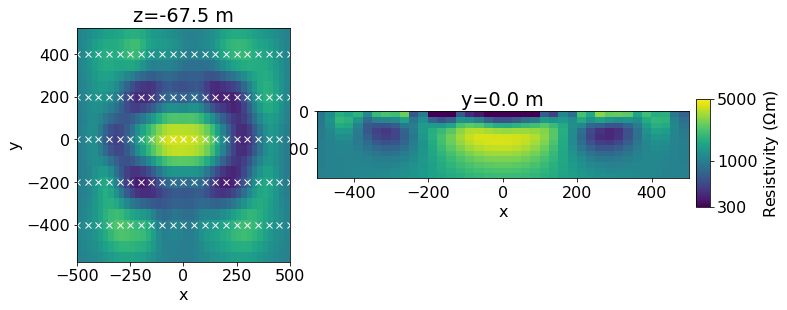

In [4]:
import matplotlib
from matplotlib import colors
matplotlib.rcParams['font.size'] = 16
sigma_est  =output_dc_inversion['sigma'].value
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 300, 5000.
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1, ticks=[300, 1000., 5000.]
)

cb.set_ticklabels(np.array([300, 1000., 5000.], dtype=int))
cb.set_label("Resistivity ($\Omega$m)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()


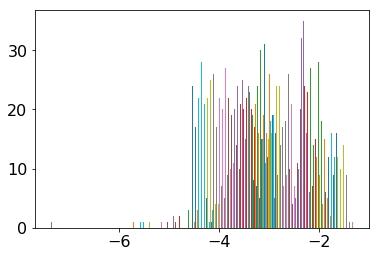

In [5]:
out = hist(np.log10(abs(IO_3d.voltages_sip)), bins=100)

In [6]:
PRED = pred.reshape((survey_3d.nD, times.size), order='F') * 1e3
DOBS = dobs.reshape((survey_3d.nD, times.size), order='F') * 1e3

(0.1, 100)

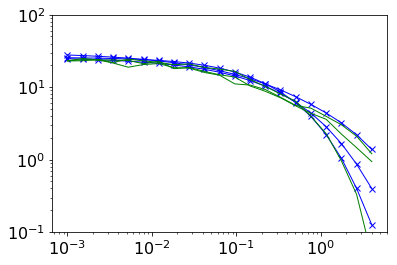

In [7]:
val = 23
dx = 0.2
inds = np.logical_and(DOBS[:,0]>val-dx, DOBS[:,0]<val+dx)
# out = plt.loglog(times, pred[inds,:].T, 'k')
# out = plt.loglog(times, pred_stepoff[inds,:].T, 'rx', lw=1, alpha=1)
out = plt.loglog(times, abs(PRED[inds,:].T), 'bx-', lw=1, alpha=1)
out = plt.loglog(times, abs(DOBS[inds,:].T), 'g', lw=1, alpha=1)
plt.ylim(0.1, 100)

In [8]:
fig_dir = "/Users/sgkang/Dropbox/spectral_ip_paper/figures/"
# fig_dir = "/home/seogi/Dropbox/spectral_ip_paper/figures/"

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


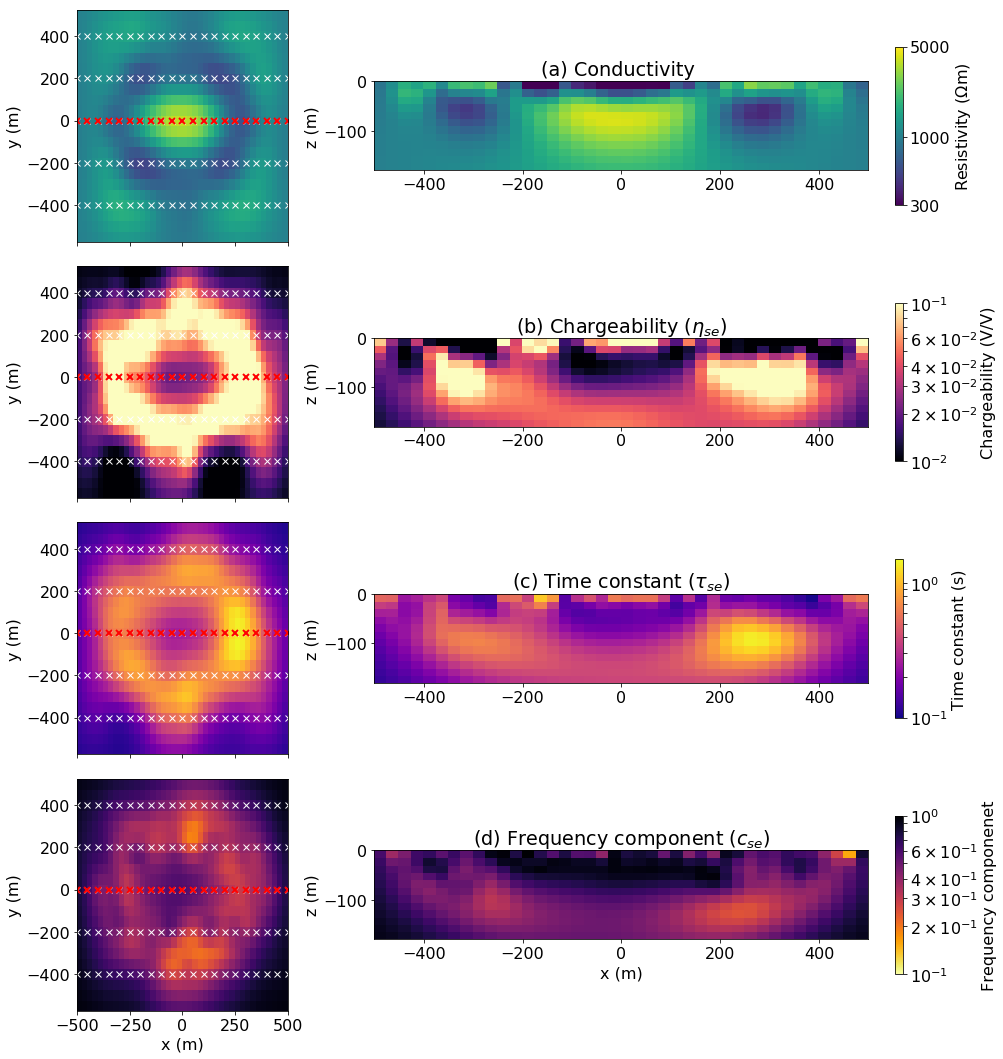

In [18]:
%pylab inline
import matplotlib
from matplotlib import colors
matplotlib.rcParams['font.size'] = 16
titles = [
            '(a) Conductivity ', 
            '(b) Chargeability ($\eta_{se}$)',
            '(c) Time constant ($\\tau_{se}$)',
            '(d) Frequency component ($c_{se}$)',    
]
sigma_est  =output_dc_inversion['sigma'].value
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -90
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))

fig = plt.figure(figsize=(14, 15))
gs = gridspec.GridSpec(4, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 300, 5000.
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
ax2.plot(IO_3d.electrode_locations[line_inds,0], IO_3d.electrode_locations[line_inds,1], 'rx', markeredgewidth=2.)
cb=plt.colorbar(
    out[0], orientation="vertical", ax=ax1, ticks=[300, 1000., 5000.], fraction=0.015
)

cb.set_ticklabels(np.array([300, 1000., 5000.], dtype=int))
cb.set_label("Resistivity ($\Omega$m)")
    
cmap = 'magma'
ax1_1 = plt.subplot(gs[1, 3:])
ax2_1 = plt.subplot(gs[1, :3])
vmin, vmax = 0.01, 0.1
out = mesh_3d_core.plotSlice(
    eta_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, ax=ax1_1, ind=indy
)
ax1_1.set_aspect("equal")
out = mesh_3d_core.plotSlice(
    eta_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, 
    ax=ax2_1
)
ax2_1.set_aspect(1)
ax2_1.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
ax2_1.plot(IO_3d.electrode_locations[line_inds,0], IO_3d.electrode_locations[line_inds,1], 'rx', markeredgewidth=2.)
cb=plt.colorbar(
    out[0], orientation="vertical", ax=ax1_1, fraction=0.015
)

cb.set_label("Chargeability (V/V)")
cmap = 'plasma'
ax1_2 = plt.subplot(gs[2, 3:])
ax2_2 = plt.subplot(gs[2, :3])
vmin, vmax = 0.1, 1.5
out = mesh_3d_core.plotSlice(
    tau_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, ax=ax1_2, ind=indy
)
ax1_2.set_aspect("equal")
out = mesh_3d_core.plotSlice(
    tau_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, 
    ax=ax2_2
)
ax2_2.set_aspect(1)
ax2_2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
ax2_2.plot(IO_3d.electrode_locations[line_inds,0], IO_3d.electrode_locations[line_inds,1], 'rx', markeredgewidth=2.)

cb=plt.colorbar(
    out[0], orientation="vertical", ax=ax1_2, fraction=0.015
)

cb.set_label("Time constant (s)")
cmap = 'inferno_r'
ax1_3 = plt.subplot(gs[3, 3:])
ax2_3 = plt.subplot(gs[3, :3])
vmin, vmax = 0.1, 1.
out = mesh_3d_core.plotSlice(
    c_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, ax=ax1_3, ind=indy
)
ax1_3.set_aspect("equal")
ax1_3.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    c_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':cmap, 'norm':colors.LogNorm()}, 
    ax=ax2_3
)
ax2_3.set_aspect(1)
ax2_3.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2_3.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
ax2_3.plot(IO_3d.electrode_locations[line_inds,0], IO_3d.electrode_locations[line_inds,1], 'rx', markeredgewidth=2.)

cb=plt.colorbar(
    out[0], orientation="vertical", ax=ax1_3, fraction=0.015
)
icount = 0
for i, ax in enumerate([ax1, ax2, ax1_1, ax2_1, ax1_2, ax2_2, ax1_3, ax2_3]):
    ax.set_xlabel("")    
    if np.mod(i, 2):
        ax.set_ylabel("y (m)")    
        ax.set_title("")
    else:
        ax.set_ylabel("z (m)")    
        ax.set_title(titles[icount])
        icount+=1
        
for ax in [ax2, ax2_1, ax2_2]:
    ax.set_xticklabels([])
ax2_3.set_xlabel("x (m)")
ax1_3.set_xlabel("x (m)")
cb.set_label("Frequency componenet")
plt.tight_layout()
fig.savefig(fig_dir+"inversion_sip_3d", dpi=200)

In [19]:
inds_true = eta>0.02
values = Utils.uniqueRows(np.c_[tau[inds_true], c[inds_true]])

In [20]:
import scipy.cluster

In [21]:
inds_eta = eta_est>0.08
inds_clay = (inds_eta) & (tau_est<1.1) & (c_est>0.6)
inds_halo = (inds_eta) & (tau_est<1.1) & (c_est<0.6)
inds_mineral = (inds_eta) & (tau_est>1.1) & (c_est<0.6)

In [22]:
rock = np.ones(mesh_3d.nC)*0.
rock[inds_halo] = 1
rock[inds_clay] = 2
rock[inds_mineral] = 3

In [23]:
mesh_3d.writeVTK("porphyry.vtr", models={'rock':rock})

/Users/sgkang/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


/Users/sgkang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


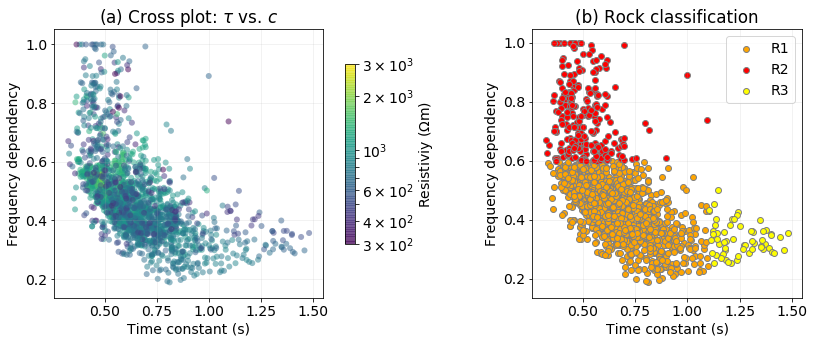

In [24]:
import matplotlib.gridspec as gs
matplotlib.rcParams['font.size'] = 14
fig = plt.figure(figsize=(14,5))
# gs = gs.GridSpec(1, 10)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
inds = eta_est > 0.08
out = ax1.scatter(
    tau_est[inds], c_est[inds], c=1./sigma_est[inds], 
    norm=colors.LogNorm(), alpha=0.5, 
    vmin=300, vmax=3000, clim=(300, 3000),
    edgecolor='None'
)
ax1.set_xscale("linear")
ax1.set_yscale("linear")
ax1.grid(which='both', alpha=0.2)
ax1.set_xlabel("Time constant (s)")
ax1.set_ylabel("Frequency dependency")
cbaxes = fig.add_axes([0.42, 0.3, 0.01, 0.5]) 
cb = plt.colorbar(out, ax=ax1, cax = cbaxes) 
cb.set_label("Resistiviy ($\Omega$m)")

inds = eta_est > 0.08
ax2.scatter(tau_est[inds_halo], c_est[inds_halo], c='orange', edgecolor='grey')
ax2.scatter(tau_est[inds_clay], c_est[inds_clay], c='red', edgecolor='grey')
ax2.scatter(tau_est[inds_mineral], c_est[inds_mineral], c='yellow', edgecolor='grey')
ax2.legend(('R1', 'R2', 'R3'), bbox_to_anchor=(1, 1))
ax2.set_xscale("linear")
ax2.set_yscale("linear")
ax2.grid(which='both', alpha=0.2)
ax2.set_xlabel("Time constant (s)")
ax2.set_ylabel("Frequency dependency")
for ax in [ax1, ax2]:
    ratio = abs(np.diff(ax1.get_xlim())) / abs(np.diff(ax1.get_ylim()))
    ax.set_aspect(ratio)
ax1.set_title("(a) Cross plot: $\\tau$ vs. $c$")
ax2.set_title("(b) Rock classification")
plt.tight_layout()
fig.savefig(fig_dir+"cross_plot", dpi=200)

In [25]:
import matplotlib as mpl
def discrete_cmap(N=4):    
    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
#     cpool = ['#00FFFF', '#3CB371','#DAA520','#DC143C','#8A2BE2']
    cpool = ['black','orange', 'red', 'yellow']
    cmap3 = mpl.colors.ListedColormap(cpool[0:N], 'indexed')
    cm.register_cmap(cmap=cmap3)
    return cmap3
geomap = discrete_cmap(N=4)    


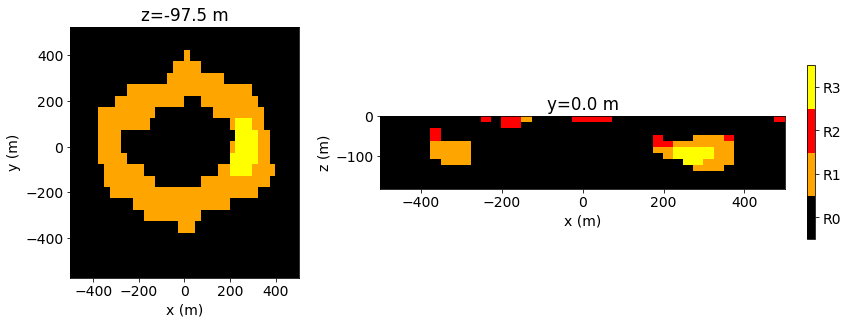

In [26]:
import matplotlib.gridspec as gs
matplotlib.rcParams['font.size'] = 14

yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -90
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])

out = mesh_3d_core.plotSlice(
    rock[core_3d_inds], grid=False, normal="Y", clim=(0, 4), pcolorOpts={'cmap':geomap}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))

out = mesh_3d_core.plotSlice(
    rock[core_3d_inds], grid=False, normal="Z", clim=(0, 4), ind=indz, pcolorOpts={'cmap':geomap}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
# ax2.plot(IO.electrode_locations[:,0], IO.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cb=plt.colorbar(
    out[0], orientation="vertical", ticks=np.arange(4)+0.5, ax=ax1, fraction=0.02
)
cb.set_ticklabels(["R0", "R1", "R2", "R3"])

for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
ax2.set_ylabel("y (m)")
ax2.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlabel("x (m)")
    
plt.tight_layout()
fig.savefig(fig_dir+"rock_model", dpi=200)